### Test SEM and npSEM algorithms on a 3d-Lorenz state-space model.
Let us consider a Lorenz-63  model
\begin{equation} 
\begin{cases}
X_t =  m(X_{t-1}) +  \eta_t, \quad \eta_t \sim \mathcal{N} \left( 0, Q\right)\\
Y_t =   H_tX_t +  \epsilon _t, \quad   \epsilon _t \sim \mathcal{N} \left( 0, R_t\right).
\end{cases}
\end{equation}

The dynamical model $m$ is defined by the following differential equation
\begin{equation} 
\begin{cases}
z(0) = x \\
\frac{dz(\tau)}{d\tau} = g(z(\tau)), \quad   \tau  \in [0,dt] \\
m(x) = z(dt)
\end{cases}
\end{equation}
where $g(z)  =\left(10(z_2-z_1), ~ z_1(28-z_3) -z_2,~  z_1z_2 - 8/3 z_3 \right)$, $~ \forall z=(z_1,z_2,z_3)^\top \in \mathbb{R}^3$.  The measurement operator $H_t$ and the covariance $R_t$ depend on the time in order to take into account situations where some of the components of $Y_t$ are not observed.

Given true error covariances  $(Q^*,R_t^*)= (\sigma _Q^{2,*}I_3, \sigma _{R_t}^{2,*} I_{n(t)})=(I_3, 2I_{n(t)})$ where $I_n$ denotes the identity matrices with dimension in $n $ and $n(t)\in \{1,2,3\}$ (corresponding to the number of components observed at time $t$), sequences of the state process $(X_t)$ and the observations process $(Y_t)$ are simulated.

The npSEM algorithm is run to reconstruct the model $m$ and estimate the parameter $\theta = (Q, \sigma _{R_t}^{2}) \in \mathbb{R}^{3 \times 3} \times \mathbb{R}$ given the observed sequence. Its results are compared to the ones derived from a SEM algorithm, SEM($m$), where both the model $m$ and the observations are provided, and the ones of another SEM algorithm, SEM($\hat m$) where both an estimate of $m$ learned on a sequence of the state process  and the observations are provided.

In [1]:
### IMPORT PACKAGES
import numpy as np
from scipy.stats import multivariate_normal
import matplotlib.pyplot as plt 
import seaborn as sns

#import L63 models
import models.l63f as mdl_l63
from models.L63 import l63_predict, l63_jac


#import routines
from methods.generate_data import generate_data
from methods.LLR_forecasting_CV import m_LLR
from methods.model_forecasting import m_true
from methods.k_choice import k_choice
from methods.CPF_BS_smoothing import _CPF_BS
from methods.SEM import CPF_BS_SEM
from methods.npSEM import LLR_CPF_BS_SEM
from methods.EnKS import _EnKS
from methods.additives import RMSE
from save_load import loadTr

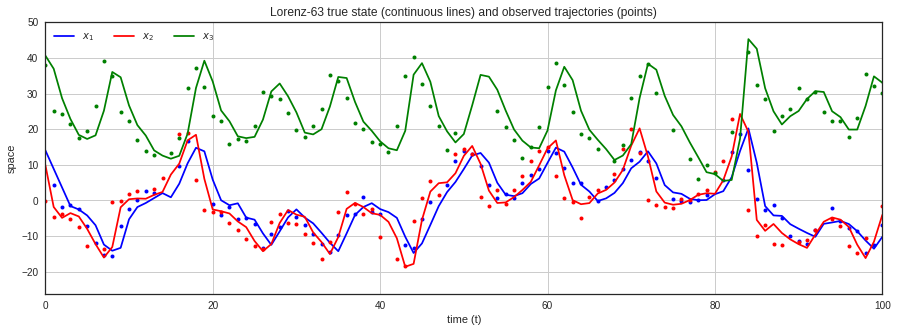

In [2]:
### GENERATE DATA (LORENZ-63 MODEL)

# parameters
dx = 3 # dimension of the state
dt_int = 0.01 # fixed integration time
dt_model = 8 # chosen number of model time step  \in [1, 25]-the larger dt_model the more nonliner model
var_obs = np.array([0,1,2]) # indices of the observed variables
dy = len(var_obs) # dimension of the observations
H = np.eye(dx)
h = lambda x: H.dot(x)  # observation model


sigma = 10.0; rho = 28.0; beta = 8.0/3 # physical parameters
fmdl=mdl_l63.M(sigma=sigma, rho=rho, beta=beta, dtcy= dt_int)
mx = lambda x: fmdl.integ(x) # fortran version (fast)
jac_mx = lambda x: l63_jac(x, dt_int*dt_model, sigma, rho, beta) # python version (slow)

# setting covariances
sig2_Q = 1; sig2_R = 2 # parameters
Q_true = np.eye(dx) *sig2_Q # model covariance
R_true = np.eye(dx) *sig2_R # observation covariance

# prior state
x0 = np.r_[8, 0, 30]

# generate data
T_burnin = 5*10**3
T_train = 10*10**2 # length of the training data
T_test = 10*10**2 # length of the testing data
X_train, Y_train, X_test, Y_test, yo = generate_data(x0,mx,h,Q_true,R_true,dt_int,dt_model,var_obs, T_burnin, T_train, T_test) 
X_train.time = np.arange(0,T_train)
Y_train.time= X_train.time[1:]

# generate missing values
#np.random.seed(0);# random number generator
N=np.size(Y_train.values);Ngap= np.floor(N/10); # create gaps: 10 percent of missing values
indX=np.random.choice(np.arange(0,N), int(Ngap), replace=False);
ind_gap_taken = divmod(indX ,len(Y_train.time));
Y_train.values[ind_gap_taken]=np.nan;

# Supplementary sequence of the state process for learing $m$ in the SEM($\hat m$) algorithm
X_train0, Y_train0, X_test0, Y_test0, yo0 = generate_data(X_train.values[:,-1],mx,h,Q_true,R_true,dt_int,dt_model,var_obs, T_burnin, T_train, T_test) 
X_train0.time = np.arange(0,T_train)
Y_train0.time= X_train0.time[1:]

## This part is to hold the same data in the paper, lock it to run the algorithms on different data
DATA_paper = loadTr('Lorenz_paper.pkl')
X_train.values = DATA_paper['X_train']
X_train0.values = DATA_paper['X_train0']
Y_train.values = DATA_paper['Y_train']

### PLOT STATE, OBSERVATIONS AND CATALOG

# state and observations (when available)
sns.set_style("white")
plt.rcParams['figure.figsize'] = (15, 5)
plt.figure(1)
plt.plot(X_train.values[0,1:].T,'b-', label='$x_1$');plt.plot(Y_train.values[0,1:].T,'.b', markersize= 8)
plt.plot(X_train.values[1,1:].T,'r-', label='$x_2$');plt.plot(Y_train.values[1,1:].T,'.r', markersize= 8)
plt.plot(X_train.values[2,1:].T,'g-', label='$x_3$');plt.plot(Y_train.values[2,1:].T,'.g', markersize= 8)
plt.legend(ncol=3)
plt.xlabel('time (t)')
plt.ylabel('space')
plt.xlim([0,100])
plt.grid()
plt.title('Lorenz-63 true state (continuous lines) and observed trajectories (points)')
plt.show()

In [3]:
np.size(np.where(np.isnan(Y_train.values)),1)


299

In [4]:
class estQ:
    value = Q_true;
    type = 'fixed' # chosen predefined type of model error covatiance ('fixed', 'adaptive')
    form = 'full' # chosen esimated matrix form ('full', 'diag', 'constant')
    base =  np.eye(dx) # for fixed base of model covariance (for 'constant' matrix form only)
    decision = True # chosen if Q is estimated or not ('True', 'False')
class estR:
    value = R_true;
    type = 'adaptive' # chosen predefined type of observation error covatiance ('fixed', 'adaptive')
    form = 'constant' # chosen esimated matrix form ('full', 'diag', 'constant')
    base =  np.eye(dx) # for fixed base of model covariance
    decision = True # chosen if R is estimated or not ('True', 'False')
class estX0:
    decision = False # chosen if X0 is estimated or not ('True', 'False')
    
class estD: # for non-parametric approach only
    decision = True # chosen if the smoothed data is updated or not ('True', 'False')
## true_FORECASTING (dynamical model)
m = lambda x,pos_x,ind_x,Q: m_true(x,pos_x,ind_x, Q, mx,jac_mx, dt_model)
num_ana = 300
data_init = np.r_['0,2,0',Y_train.values[...,:-1], Y_train.values[...,1:]];
ind_nogap = np.where(~np.isnan(np.sum(data_init,0)))[0]; 
#  LLR_FORECASTING (non-parametric dynamical model constructed given the catalog)
# parameters of the analog forecasting method
class LLR:
    class data:
        ana = np.zeros((dx,1,len(ind_nogap))); suc = np.zeros((dx,1,len(ind_nogap)));
        ana[:,0,:] =data_init[:dx,ind_nogap]; suc[:,0,:]  = data_init[dx:,ind_nogap]; time = Y_train.time[ind_nogap] # catalog with analogs and successors
#        ana = X_train.values[...,:-1]; suc =X_train.values[...,1:]; time = X_train.time[:-1]#catalog with analogs and successors
    class data_prev:
        ana =data_init[:dx,ind_nogap]; suc = data_init[dx:,ind_nogap]; time = Y_train.time[ind_nogap] # catalog with analogs and successors
    lag_x = 5 # lag of removed analogs around x to avoid an over-fitting forecast
    lag_Dx = lambda Dx: np.shape(Dx)[-1]; #15 lag of moving window of analogs chosen around x 
    time_period = 1 # set 365.25 for year and 
    k_m = [] # number of analogs 
    k_Q = [] # number of analogs 
    nN_m = np.arange(20,num_ana,50) #number of analogs to be chosen for mean estimation
    nN_Q = np.arange(20,num_ana,50) #number of analogs to be chosen for dynamical error covariance
    lag_k = 1; #chosen the lag for k reestimation 
    estK = 'same' # set 'same' if k_m = k_Q chosen, otherwise, set 'different'
    kernel = 'tricube'# set 'rectangular' or 'tricube'
    k_lag = 20;
    k_inc= 10
    Q = estQ;
    gam = 1;


In [5]:
# SETTING PARAMETERS 
X_conditioning = np.zeros([dx,T_train+1]) # the conditioning trajectory 
B = Q_true
xb= X_train.values[...,0]
Nf = 10# number of particles
Ns = 5 # number of realizations

N_iter =500# number of iterations of EM algorithms
# Step functions
gam1 = np.ones(N_iter,dtype=int)  #for SEM (stochastic EM)
gam2 = np.ones(N_iter, dtype=int)
for k in range(50,N_iter):
    gam2[k] = k**(-0.7) # for SAEM (stochastic approximation EM)
#gam1 = gam2

# initial parameters
aintQ = 0.5; bintQ = 5
aintR = 1; bintR = 5
R_init = .5*np.eye(dy)    
Q_init = 3*np.eye(dx)
LLR.Q.value = Q_init


In [6]:
### (SEM): STOCHASTIC EXPECATION-MAXIMIZATION  vs (npSEM): NON-PARAMETRIC STOCHASTIC EXPECATION-MAXIMIZATION 

## SEM[m] 
m = lambda x,pos_x,ind_x,Q: m_true(x,pos_x,ind_x, Q, mx,jac_mx, dt_model) # true forecast model

# run EnKS for generating the fisrt conditioning trajectory 
m_init = lambda  x,pos_x,ind_x: m(x,pos_x,ind_x, Q_init)
Xs, _, _ = _EnKS(dx, 20, len(Y_train.time), H, R_init, Y_train.values,X_train.values, dy, xb, B, Q_init, 1, m_init)
X_conditioning = np.squeeze(Xs.mean(1))

# outputs of SEM[m] algorithm
out_SEM = CPF_BS_SEM(Y_train.values,X_train.values, m, Q_init, H, R_init, xb , B, X_conditioning, dx, Nf, Ns, X_train.time,N_iter,gam1,estQ,estR,estX0)
  

## SEM[\hat m] 
estD.decision = False; 
LLR.Q.value = Q_init
LLR.data.ana = np.zeros((dx,1,T_train-1)); LLR.data.suc = np.zeros((dx,1,T_train-1));
LLR.data.ana[:,0,:] =X_train0.values[...,:-1]; LLR.data.suc[:,0,:] = X_train0.values[...,1:]; LLR.data.time = X_train.time[:-1]
k_m, k_Q = k_choice(LLR,LLR.data.ana,LLR.data.suc,LLR.data.time) # choose an optimal number of neighbors used in LLR forecast
LLR.k_m =k_m; LLR.k_Q =k_Q; 

LLR.lag_x =0; 
m_hat = lambda  x,pos_x,ind_x: m_LLR(x,pos_x,ind_x,LLR) # LLR forecast model
# run EnKS for generating the fisrt conditioning trajectory 
Xs, _, _ = _EnKS(dx, 20, len(Y_train.time), H, R_init, Y_train.values,X_train.values, dy, xb, B, Q_init, 1, m_hat)
X_conditioning = np.squeeze(Xs.mean(1))

# outputs of SEM[\hat m] algorithm
out_SEM_hat = LLR_CPF_BS_SEM(Y_train.values,X_train.values, LLR, H, R_init,xb,B, X_conditioning,dx, Nf, Ns,X_train.time, N_iter, gam1, estD, estQ, estR, estX0)
    

## npSEM   
estD.decision = True;  LLR.lag_x =5;  LLR.Q = estQ; LLR.nN_m = np.arange(20,num_ana,50); LLR.nN_Q = LLR.nN_m
LLR.data.ana = np.zeros((dx,1,len(ind_nogap))); LLR.data.suc = np.zeros((dx,1,len(ind_nogap)));
LLR.data.ana[:,0,:] =data_init[:dx,ind_nogap]; LLR.data.suc[:,0,:] = data_init[dx:,ind_nogap]; LLR.data.time = Y_train.time[ind_nogap] 

LLR.Q.value = Q_init
k_m, k_Q = k_choice(LLR,LLR.data.ana,LLR.data.suc,LLR.data.time) # choose an optimal number of neighbors used in LLR forecast
LLR.k_m =k_m; LLR.k_Q =k_Q; 
    
m_hat = lambda  x,pos_x,ind_x: m_LLR(x,pos_x,ind_x,LLR) # LLR forecast model
# run EnKS for generating the fisrt conditioning trajectory 
Xs, _, _ = _EnKS(dx, 20, len(Y_train.time), H, R_init, Y_train.values,X_train.values, dy, xb, B, Q_init, 1, m_hat)
X_conditioning = np.squeeze(Xs.mean(1))
    
# outputs of npSEM algorithm    
out_npSEM = LLR_CPF_BS_SEM(Y_train.values,X_train.values, LLR, H, R_init,xb,B, X_conditioning,dx, Nf, Ns,X_train.time, N_iter, gam1, estD, estQ, estR, estX0)

    



100%|██████████| 500/500 [7:36:02<00:00, 46.89s/it]   


In [7]:

## results
ii =0; ilim =0
# SEM
Q_SEM = out_SEM['EM_state_error_covariance'][:,:,ii:]
R_SEM= out_SEM['EM_observation_error_covariance'][:,:,ii:]
loglik_SEM= out_SEM['loglikelihood'][ii:]
Xs_SEM = out_SEM['smoothed_samples']

Q_SEM_hat = out_SEM_hat['EM_state_error_covariance'][:,:,ii:]
R_SEM_hat = out_SEM_hat['EM_observation_error_covariance'][:,:,ii:]
loglik_SEM_hat= out_SEM_hat['loglikelihood'][ii:]
Xs_SEM_hat = out_SEM_hat['smoothed_samples']

Q_npSEM = out_npSEM['EM_state_error_covariance'][:,:,ii:]
R_npSEM= out_npSEM['EM_observation_error_covariance'][:,:,ii:]
loglik_npSEM= out_npSEM['loglikelihood'][ii:]
Xs_npSEM = out_npSEM['smoothed_samples']
k_opt = out_npSEM['optimal_number_analogs'][:,ii:]



### COMPUTE LOG-LIKELIHOOD RATIO STATISTICS AND ROOT OF MEAN SQUARE ERROR
ilim=N_iter; LLR.lag_x =5
T_SEM  = np.zeros([ilim])
T_SEM_hat  = np.zeros([ilim])
T_npSEM  = np.zeros([ilim])

RMSE_x_SEM  = np.zeros([ilim])
RMSE_x_SEM_hat  = np.zeros([ilim])
RMSE_x_npSEM  = np.zeros([ilim])
LLR.data.time = np.arange(T_train-1)

# true forecast
_, mean_xft,_, _ =  m(X_train.values[:,:-1],1,np.ones([1]), Q_true)
T_0 = np.sum(np.log(multivariate_normal.pdf(X_train.values[:,1:].T-mean_xft.T,np.zeros([dx]) ,Q_true)))

LLR.lag_x =5; LLR.nN_m = np.arange(20,num_ana,50) ; LLR.nN_Q = np.arange(20,num_ana,50) 
LLR.data.ana = np.zeros((dx,1,T_train-1)); LLR.data.suc = np.zeros((dx,1,T_train-1));
LLR.data.ana[:,0,:] =X_train0.values[:,:-1]; LLR.data.suc[:,0,:]  = X_train0.values[:,1:]; LLR.data.time = X_train.time[:-1] # catalog with analogs and successors
k_m, k_Q = k_choice(LLR,LLR.data.ana,LLR.data.suc,LLR.data.time)
LLR.k_m=k_m; LLR.k_Q=k_Q; 
LLR.lag_x =0
xf, mean_xff, Q_xf, M_xf = m_LLR(X_train.values[:,:-1],1,np.ones([1]),LLR) 



for i in range(ilim):
    Q_i = Q_SEM[...,i]
    T_SEM[i] = np.sum(np.log(multivariate_normal.pdf(X_train.values[:,1:].T-mean_xft.T,np.zeros([dx]) ,Q_i)))
    RMSE_x_SEM[i]= RMSE(np.mean(Xs_SEM[:,:,:,i+1],1)-X_train.values)
  
    Q_xf_i = Q_SEM_hat[...,i]
    T_SEM_hat[i] = np.sum(np.log(multivariate_normal.pdf(X_train.values[:,1:].T-mean_xff.T,np.zeros([dx]) ,Q_xf_i)))
    RMSE_x_SEM_hat[i]= RMSE(np.mean(Xs_SEM_hat[:,:,:,i+1],1)-X_train.values)
   

    if i==0:
        LLR.lag_x =5
        LLR.data.ana = np.zeros((dx,1,len(ind_nogap))); LLR.data.suc = np.zeros((dx,1,len(ind_nogap)));
        LLR.data.ana[:,0,:] =data_init[:dx,ind_nogap]; LLR.data.suc[:,0,:]  = data_init[dx:,ind_nogap]; LLR.data.time = Y_train.time[ind_nogap]  # catalog with analogs and successors
        k_m, k_Q = k_choice(LLR,LLR.data.ana,LLR.data.suc,LLR.data.time)
        LLR.k_m=k_m; LLR.k_Q=k_Q; 
        
    else:
        LLR.data.ana= Xs_npSEM[:,:,:-1,i]; LLR.data.suc= Xs_npSEM[:,:,1:,i]; LLR.data.time = X_train.time[:-1]
        LLR.k_m = k_opt[0,i]; LLR.k_Q= LLR.k_m
    
    _, mean_xf_i, _, _ = m_LLR(X_train.values[:,:-1],1,np.ones([1]),LLR)
    Q_xf_i = Q_npSEM[...,i]
    T_npSEM[i] = np.sum(np.log(multivariate_normal.pdf(X_train.values[:,1:].T-mean_xf_i.T,np.zeros([dx]) ,Q_xf_i)))
    RMSE_x_npSEM[i]= RMSE(np.mean(Xs_npSEM[:,:,:,i+1],1)-X_train.values)


Convergence results


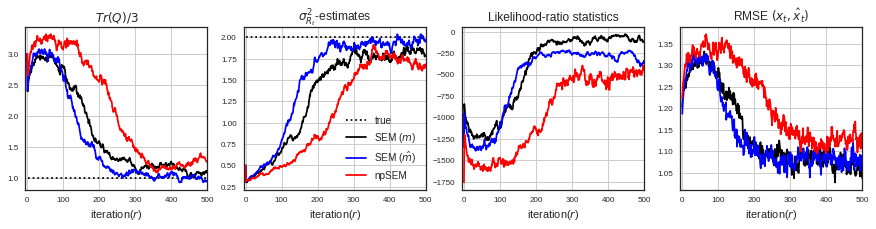

In [19]:
# Plot of convergence results
print('Convergence results')
plt.rcParams['figure.figsize'] = (15, 3) 
plt.rc('xtick', labelsize= 8) 
plt.rc('ytick', labelsize= 8)
plt.figure()
plt.subplot(141)
line1,=plt.plot((1,N_iter),(np.trace(Q_true)/dx,np.trace(Q_true)/dx),'k:')
line2,=plt.plot(np.trace(Q_SEM)/dx,color = 'k')
line3,=plt.plot(np.trace(Q_SEM_hat)/dx,color =  'b')
line4,=plt.plot(np.trace(Q_npSEM)/dx,color = 'r')
plt.xlabel('iteration($r$)')
plt.title('$Tr(Q)/3$')
plt.xlim([-5,ilim])
plt.grid()

# plot sig2_R estimates
plt.subplot(142)
line1,=plt.plot((1,N_iter),(np.trace(R_true)/dx,np.trace(R_true)/dx),'k:')
line2,=plt.plot(np.trace(R_SEM)/dy,color = 'k')
line3,=plt.plot(np.trace(R_SEM_hat)/dy,color =  'b')
line4,=plt.plot(np.trace(R_npSEM)/dx,color = 'r')
plt.xlabel('iteration($r$)')
plt.legend([line1,line2,line3,line4],['true','SEM ($m$)','SEM ($\hat m$)','npSEM'])
plt.title('$\sigma_{R_t}^2$-estimates')
plt.xlim([-5,ilim])

plt.grid()
plt.subplot(143)
line1,=plt.plot(-2*(T_0-T_SEM),color = 'k')
line2,=plt.plot(-2*(T_0-T_SEM_hat),color = 'b')
line3,=plt.plot(-2*(T_0-T_npSEM),color = 'r')
plt.xlabel('iteration($r$)')
plt.title('Likelihood-ratio statistics')
plt.xlim([-5,ilim])
plt.grid()

plt.subplot(144)
line1,=plt.plot(RMSE_x_SEM,color = 'k')
line2,=plt.plot(RMSE_x_SEM_hat,color = 'b')
line3,=plt.plot(RMSE_x_npSEM,color = 'r')
plt.xlabel('iteration($r$)')
plt.title('RMSE $(x_t,\hat x_t )$')
plt.xlim([-5,ilim])
plt.grid()
plt.show()


Scattet plots of $(Y_{t-1}, Y_t)$ of the observations,  $(X_{t-1}, X_t)$ of the state and $(\~X_{t-1},\~ X_t)$ generated from npSEM algorithm


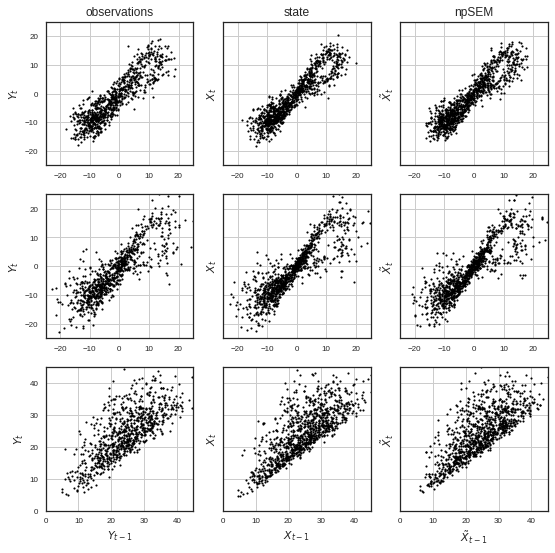

In [26]:
### 'Scattet plots of $(Y_{t-1}, Y_t)$ of the observations,  $(X_{t-1}, X_t)$ of the state and $(\~X_{t-1},\~ X_t)$ generated from npSEM algorithm
print('Scattet plots of $(Y_{t-1}, Y_t)$ of the observations,  $(X_{t-1}, X_t)$ of the state and $(\~X_{t-1},\~ X_t)$ generated from npSEM algorithm')
plt.rcParams['figure.figsize'] = (9, 9)               
plt.figure()
plt.subplot(331)
var = 0
plt.scatter(Y_train.values[var,:-1],Y_train.values[var,1:],color = 'k',s = 3)
plt.xlim([-25,25]); plt.ylim([-25,25])
plt.title('observations')
plt.ylabel('$Y_{t}$')
plt.grid()

plt.subplot(332)
plt.scatter(X_train.values[var,:-1],X_train.values[var,1:],color = 'k', s = 3)# [0.5,0.5,0.5]
plt.xlim([-25,25]); plt.ylim([-25,25])
plt.title('state')
plt.ylabel('$X_{t}$')
plt.tick_params(labelleft='off')
plt.grid()

plt.subplot(333)
plt.scatter(Xs_npSEM[var,0,:-1,-1],Xs_npSEM[var,0,1:,-1],color  = 'k', s = 3)
plt.xlim([-25,25]); plt.ylim([-25,25])
plt.title('npSEM')
plt.tick_params(labelleft='off')
plt.ylabel('$\~X_{t}$')
plt.grid()

plt.subplot(334)
var = 1
plt.scatter(Y_train.values[var,:-1],Y_train.values[var,1:],color = 'k',s = 3)
plt.xlim([-25,25]); plt.ylim([-25,25])
plt.ylabel('$Y_{t}$')
plt.grid()

plt.subplot(335)
plt.scatter(X_train.values[var,:-1],X_train.values[var,1:],color = 'k', s = 3)
plt.xlim([-25,25]); plt.ylim([-25,25])
plt.ylabel('$X_{t}$')
plt.tick_params(labelleft='off')
plt.grid()

plt.subplot(336)
plt.scatter(Xs_npSEM[var,0,:-1,-1],Xs_npSEM[var,0,1:,-1],color  = 'k',s = 3)
plt.xlim([-25,25]); plt.ylim([-25,25])
plt.ylabel('$\~X_{t}$')
plt.tick_params(labelleft='off')
plt.grid()

plt.subplot(337)
var = 2
plt.scatter(Y_train.values[var,:-1],Y_train.values[var,1:],color = 'k',s = 3)
plt.xlim([0,45]); plt.ylim([0,45])
plt.xlabel('$Y_{t-1}$')
plt.ylabel('$Y_{t}$')
plt.grid()

plt.subplot(338)
plt.scatter(X_train.values[var,:-1],X_train.values[var,1:],color = 'k', s = 3)# [0.5,0.5,0.5]
plt.xlim([0,45]); plt.ylim([0,45])
plt.tick_params(labelleft='off')
plt.xlabel('$X_{t-1}$')
plt.ylabel('$X_{t}$')
plt.grid()

plt.subplot(339)
plt.scatter(Xs_npSEM[var,0,:-1,-1],Xs_npSEM[var,0,1:,-1],color  = 'k', s = 3) 
plt.xlim([0,45]); plt.ylim([0,45])
plt.xlabel('$\~X_{t-1}$')
plt.ylabel('$\~X_{t}$')
plt.tick_params(labelleft='off')
plt.grid()
plt.show()